<a id="introduction"></a>
## Introduction to RAPIDS
#### By Paul Hendricks
-------

While the world’s data doubles each year, CPU computing has hit a brick wall with the end of Moore’s law. For the same reasons, scientific computing and deep learning has turned to NVIDIA GPU acceleration, data analytics and machine learning where GPU acceleration is ideal. 

NVIDIA created RAPIDS – an open-source data analytics and machine learning acceleration platform that leverages GPUs to accelerate computations. RAPIDS is based on Python, has Pandas-like and Scikit-Learn-like interfaces, is built on Apache Arrow in-memory data format, and can scale from 1 to multi-GPU to multi-nodes. RAPIDS integrates easily into the world’s most popular data science Python-based workflows. RAPIDS accelerates data science end-to-end – from data prep, to machine learning, to deep learning. And through Arrow, Spark users can easily move data into the RAPIDS platform for acceleration.

In this notebook, we will discuss and show at a high level what each of the packages in the RAPIDS are as well as what they do. Subsequent notebooks will dive deeper into the various areas of data science and machine learning and show how you can use RAPIDS to accelerate your workflow in each of these areas.

**Table of Contents**

* [Introduction to RAPIDS](#introduction)
* [Setup](#setup)
* [Pandas](#pandas)
* [cuDF](#cudf)
* [Scikit-Learn](#scikitlearn)
* [cuML](#cuml)
* [Dask](#dask)
* [Dask cuDF](#daskcudf)
* [Conclusion](#conclusion)

Before going any further, let's make sure we have access to `matplotlib`, a popular Python library for visualizing data.  The Conda install of RAPIDS no longer includes it by default, but the Docker install does.

In [1]:
import os
try:
    import matplotlib
except ModuleNotFoundError:
    os.system('conda install -y matplotlib')

<a id="setup"></a>
## Setup

This notebook was tested using the [RAPIDS Stable Conda channel, versions 0.17 and 0.18](https://anaconda.org/rapidsai/rapids), and the following Docker containers:

* `rapidsai/rapidsai-dev:0.18-cuda10.2-devel-ubuntu18.04-py3.7` container from [DockerHub](https://hub.docker.com/r/rapidsai/rapidsai)

This notebook was run on the NVIDIA GV100 GPU, the Quardo RTX8000, and the T4. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

If you think you have found a bug or an error, please file an issue here: https://github.com/rapidsai/notebooks-contrib/issues

Before we begin, let's check out our hardware setup by running the `nvidia-smi` command.

In [3]:
!nvidia-smi

Wed Oct  1 13:48:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:01:00.0  On |                  N/A |
| 56%   52C    P5             36W /  320W |    2818MiB /  10240MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Next, let's see what CUDA version we have.  If it's not found, that's okay, you may not have nvcc or be in a Docker container.

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Mon_Oct_24_19:12:58_PDT_2022
Cuda compilation tools, release 12.0, V12.0.76
Build cuda_12.0.r12.0/compiler.31968024_0


Next, let's load some helper functions from `matplotlib` and configure the Jupyter Notebook for visualization.

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


%matplotlib inline

Let's see how much GPU memory is available.  Since this is a tutorial, we want to keep that data as big as possible without you running out of memory (OOM).

In [8]:
pip install pynvml

Note: you may need to restart the kernel to use updated packages.


In [9]:
from pynvml.smi import nvidia_smi
nvsmi = nvidia_smi.getInstance()
gpus = nvsmi.DeviceQuery()

gpu_mem = int(gpus['gpu'][0]['fb_memory_usage']['total']/1000)  #gets your memory size of your first found GPU in GB
print("your GPU has", gpu_mem, "GB")

ModuleNotFoundError: No module named 'pynvml.smi'; 'pynvml' is not a package

<a id="pandas"></a>
## Pandas

Data scientists typically work with two types of data: unstructured and structured. Unstructured data often comes in the form of text, images, or videos. Structured data - as the name suggests - comes in a structured form, often represented by a table or CSV. We'll focus the majority of these tutorials on working with these types of data.

There exist many tools in the Python ecosystem for working with structured, tabular data but few are as widely used as Pandas. Pandas represents data in a table and allows a data scientist to manipulate the data to perform a number of useful operations such as filtering, transforming, aggregating, merging, visualizing and many more. 

For more information on Pandas, check out the excellent documentation: http://pandas.pydata.org/pandas-docs/stable/

Below we show how to create a Pandas DataFrame, an internal object for representing tabular data.

In [10]:
import pandas as pd; print('Pandas Version:', pd.__version__)


# here we create a Pandas DataFrame with
# two columns named "key" and "value"
df = pd.DataFrame()
df['key'] = [0, 0, 2, 2, 3]
df['value'] = [float(i + 10) for i in range(5)]
print(df)

Pandas Version: 2.3.3
   key  value
0    0   10.0
1    0   11.0
2    2   12.0
3    2   13.0
4    3   14.0


We can perform many operations on this data. For example, let's say we wanted to sum all values in the in the `value` column. We could accomplish this using the following syntax:

In [11]:
aggregation = df['value'].sum()
print(aggregation)

60.0


<a id="cudf"></a>
## cuDF

Pandas is fantastic for working with small datasets that fit into your system's memory. However, datasets are growing larger and data scientists are working with increasingly complex workloads - the need for accelerated compute arises.

cuDF is a package within the RAPIDS ecosystem that allows data scientists to easily migrate their existing Pandas workflows from CPU to GPU, where computations can leverage the immense parallelization that GPUs provide.

Below, we show how to create a cuDF DataFrame.

In [12]:
import cudf; print('cuDF Version:', cudf.__version__)


# here we create a cuDF DataFrame with
# two columns named "key" and "value"
df = cudf.DataFrame()
df['key'] = [0, 0, 2, 2, 3]
df['value'] = [float(i + 10) for i in range(5)]
print(df)

cuDF Version: 25.12.00a114
   key  value
0    0   10.0
1    0   11.0
2    2   12.0
3    2   13.0
4    3   14.0


As before, we can take this cuDF DataFrame and perform a `sum` operation over the `value` column. The key difference is that any operations we perform using cuDF use the GPU instead of the CPU.

In [9]:
aggregation = df['value'].sum()
print(aggregation)

60.0


Note how the syntax for both creating and manipulating a cuDF DataFrame is identical to the syntax necessary to create and manipulate Pandas DataFrames; the cuDF API is based on the Pandas API. This design choice minimizes the cognitive burden of switching from a CPU based workflow to a GPU based workflow and allows data scientists to focus on solving problems while benefitting from the speed of a GPU!

<a id="scikitlearn"></a>
## Scikit-Learn

After our data has been preprocessed, we often want to build a model so as to understand the relationships between different variables in our data. Scikit-Learn is an incredibly powerful toolkit that allows data scientists to quickly build models from their data. Below we show a simple example of how to create a Linear Regression model.

In [14]:
import numpy as np; print('NumPy Version:', np.__version__)


# create the relationship: y = 2.0 * x + 1.0
#if(gpu_mem <= 16):
n_rows = 35000 # let's use 35 thousand data points.  Very small GPU memory sizes will require you to reduce this number further 
#elif(gpu_mem > 17):
#    n_rows = 100000 # let's use 100 thousand data points
w = 2.0
x = np.random.normal(loc=0, scale=1, size=(n_rows,))
b = 1.0
y = w * x + b

# add a bit of noise
noise = np.random.normal(loc=0, scale=2, size=(n_rows,))
y_noisy = y + noise

NumPy Version: 2.2.6


We can now visualize our data using the `matplotlib` library.

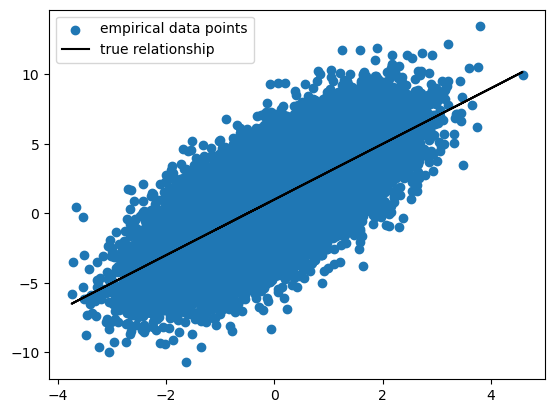

In [15]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.legend()

We'll use the `LinearRegression` class from Scikit-Learn to instantiate a model and fit it to our data.

In [16]:
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.linear_model import LinearRegression


# instantiate and fit model
linear_regression = LinearRegression()

Scikit-Learn Version: 1.7.2


In [17]:
%%time

linear_regression.fit(np.expand_dims(x, 1), y)

CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 11.1 ms


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [18]:
# create new data and perform inference
inputs = np.linspace(start=-5, stop=5, num=1000)
outputs = linear_regression.predict(np.expand_dims(inputs, 1))

Let's now visualize our empirical data points, the true relationship of the data, and the relationship estimated by the model. Looks pretty close!

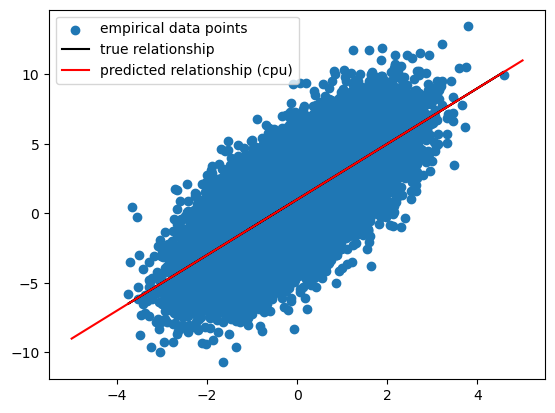

In [19]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.legend()

<a id="cuml"></a>
## cuML

The mathematical operations underlying many machine learning algorithms are often matrix multiplications. These types of operations are highly parallelizable and can be greatly accelerated using a GPU. cuML makes it easy to build machine learning models in an accelerated fashion while still using an interface nearly identical to Scikit-Learn. The below shows how to accomplish the same Linear Regression model but on a GPU.

First, let's convert our data from a NumPy representation to a cuDF representation.

In [20]:
# create a cuDF DataFrame
df = cudf.DataFrame({'x': x, 'y': y_noisy})
print(df.head())

          x         y
0 -0.098902  0.877937
1 -0.801637 -4.450111
2 -0.157945  2.276937
3 -1.093385  1.489469
4  1.820465 -0.734233


Next, we'll load the GPU accelerated `LinearRegression` class from cuML, instantiate it, and fit it to our data.

In [21]:
import cuml; print('cuML Version:', cuml.__version__)
from cuml.linear_model import LinearRegression as LinearRegression_GPU


# instantiate and fit model
linear_regression_gpu = LinearRegression_GPU()

cuML Version: 25.12.00a28


In [22]:
%%time

linear_regression_gpu.fit(df[['x']], df['y'])

/opt/conda/lib/python3.12/site-packages/cuml/internals/api_decorators.py:211: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  ret = func(*args, **kwargs)


CPU times: user 254 ms, sys: 51.1 ms, total: 306 ms
Wall time: 557 ms


LinearRegression()

We can use this model to predict values for new data points, a step often called "inference" or "scoring". All model fitting and predicting steps are GPU accelerated.

In [23]:
# create new data and perform inference
new_data_df = cudf.DataFrame({'inputs': inputs})
outputs_gpu = linear_regression_gpu.predict(new_data_df[['inputs']])

Lastly, we can overlay our predicted relationship using our GPU accelerated Linear Regression model (green line) over our empirical data points (light blue circles), the true relationship (blue line), and the predicted relationship from a model built on the CPU (red line). We see that our GPU accelerated model's estimate of the true relationship (green line) is identical to the CPU based model's estimate of the true relationship (red line)!

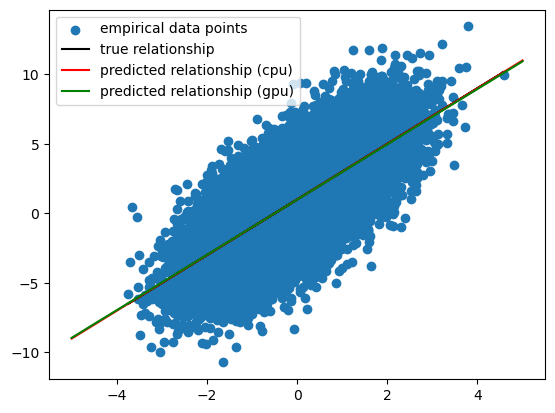

In [25]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.plot(inputs, outputs_gpu, color='green', label='predicted relationship (gpu)')
plt.legend()

<a id="dask"></a>
## Dask

Dask is a library the allows facillitates distributed computing. Written in Python, it allows one to compose complex workflows using basic Python primitives like integers or strings as well as large data structures like those found in NumPy, Pandas, and cuDF. In the following examples and notebooks, we'll show how to use Dask with cuDF to accelerate common ETL tasks and train machine learning models like Linear Regression and XGBoost.

To learn more about Dask, check out the documentation here: http://docs.dask.org/en/latest/

#### Client/Workers

Dask operates by creating a cluster composed of a "client" and multiple "workers". The client is responsible for scheduling work; the workers are responsible for actually executing that work. 

Typically, we set the number of workers to be equal to the number of computing resources we have available to us. For CPU based workflows, this might be the number of cores or threads on that particlular machine. For example, we might set `n_workers = 8` if we have 8 CPU cores or threads on our machine that can each operate in parallel. This allows us to take advantage of all of our computing resources and enjoy the most benefits from parallelization.

To get started, we'll create a local cluster of workers and client to interact with that cluster.

In [28]:
import dask; print('Dask Version:', dask.__version__)
from dask.distributed import Client, LocalCluster


# create a local cluster with 4 workers
n_workers = 4
cluster = LocalCluster(n_workers=n_workers)
client = Client(cluster)

Dask Version: 2025.9.1


/opt/conda/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34131 instead
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/rapids_dask_dependency/dask_loader.py:36: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  return importlib.import_module(spec.name)
/opt/conda/lib/python3.12/site-packages/rapids_dask_dependency/dask_loader.py:36: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  return importlib.import_module(spec.name)
/opt/conda/lib/python3.12/site-packages/rapids_dask_dependency/dask_loader.py:36: FutureWarning: The pynvml packag

Let's inspect the `client` object to view our current Dask status. We should see the IP Address for our Scheduler as well as the the number of workers in our Cluster. 

In [29]:
# show current Dask status
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34131/status,
Dashboard: http://127.0.0.1:34131/status,Workers: 4
Total threads: 20,Total memory: 39.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42973,Workers: 0
Dashboard: http://127.0.0.1:34131/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46385,Total threads: 5
Dashboard: http://127.0.0.1:43007/status,Memory: 9.77 GiB
Nanny: tcp://127.0.0.1:40259,


You can also see the status and more information at the Dashboard, found at `http://<ip_address>/status`. You can ignore this for now, we'll dive into this in subsequent tutorials.

With our client and cluster of workers setup, it's time to execute our first distributed program. We'll define a function called `sleep_1` that sleeps for 1 second and returns the string "Success!". Executed in serial four times, this function should take around 4 seconds to execute.

In [30]:
import time


def sleep_1():
    time.sleep(1)
    return 'Success!'

In [31]:
%%time

for _ in range(n_workers):
    sleep_1()

CPU times: user 321 ms, sys: 31.6 ms, total: 353 ms
Wall time: 4 s


As expected, our workflow takes about 4 seconds to run. Now let's execute this same workflow in distributed fashion using Dask.

In [32]:
from dask.delayed import delayed

In [33]:
%%time

print("Workers:", n_workers)
# define delayed execution graph
sleep_operations = [delayed(sleep_1)() for _ in range(n_workers)]

# use client to perform computations using execution graph
sleep_futures = client.compute(sleep_operations, optimize_graph=False, fifo_timeout="0ms")

# collect and print results
sleep_results = client.gather(sleep_futures)
print(sleep_results)

Workers: 4
['Success!', 'Success!', 'Success!', 'Success!']
CPU times: user 101 ms, sys: 6.46 ms, total: 108 ms
Wall time: 1.02 s


Using Dask, we see that this whole workflow takes a little over a second - each worker is truly executing in parallel!

<a id="daskcudf"></a>
## Dask cuDF

In the previous example, we saw how we can use Dask with very basic objects to compose a graph that can be executed in a distributed fashion. However, we aren't limited to basic data types though. 

We can use Dask with objects such as Pandas DataFrames, NumPy arrays, and cuDF DataFrames to compose more complex workflows. With larger amounts of data and embarrasingly parallel algorithms, Dask allows us to scale ETL and Machine Learning workflows to Gigabytes or Terabytes of data. In the below example, we show how we can process 100 million rows by combining cuDF with Dask.

Before we start working with cuDF DataFrames with Dask, we need to setup a Local CUDA Cluster and Client to work with our GPUs. This is very similar to how we setup a Local Cluster and Client in vanilla Dask.

In [34]:
import dask; print('Dask Version:', dask.__version__)
from dask.distributed import Client
# import dask_cuda; print('Dask CUDA Version:', dask_cuda.__version__)
from dask_cuda import LocalCUDACluster


# create a local CUDA cluster
cluster = LocalCUDACluster()
client = Client(cluster)

Dask Version: 2025.9.1


/opt/conda/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45239 instead
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/dask_cuda/utils.py:201: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/rapids_dask_dependency/dask_loader.py:36: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  return importlib.import_module(spec.name)


Let's inspect our `client` object:

In [28]:
client

Client Scheduler: tcp://127.0.0.1:36027 Dashboard: http://127.0.0.1:45317/status,Cluster Workers: 1 Cores: 1 Memory: 16.48 GB


As before, you can also see the status of the Client along with information on the Scheduler and Dashboard.

With our client and workers setup, let's create our first distributed cuDF DataFrame using Dask. We'll instantiate our cuDF DataFrame in the same manner as the previous sections but instead we'll use significantly more data. Lastly, we'll pass the cuDF DataFrame to `dask_cudf.from_cudf` and create an object of type `dask_cudf.core.DataFrame`.

In [35]:
import dask_cudf; print('Dask cuDF Version:', dask_cudf.__version__)


# identify number of workers
workers = client.has_what().keys()
n_workers = len(workers)

# create a cuDF DataFrame with two columns named "key" and "value"
df = cudf.DataFrame()
n_rows = 100000000  # let's process 100 million rows in a distributed parallel fashion
df['key'] = np.random.binomial(1, 0.2, size=(n_rows))
df['value'] = np.random.normal(size=(n_rows))

# create a distributed cuDF DataFrame using Dask
distributed_df = dask_cudf.from_cudf(df, npartitions=n_workers)

Dask cuDF Version: 25.12.00a114


In [36]:
# inspect our distributed cuDF DataFrame using Dask
print('-' * 15)
print('Type of our Dask cuDF DataFrame:', type(distributed_df))
print('-' * 15)
print(distributed_df.head())

---------------
Type of our Dask cuDF DataFrame: <class 'dask_cudf._expr.collection.DataFrame'>
---------------


/opt/conda/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 1.49 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


   key     value
0    1 -0.426557
1    0  1.826683
2    0 -0.348733
3    0  1.644021
4    0  0.606504


The above output shows the first several rows of our distributed cuDF DataFrame.

With our Dask cuDF DataFrame defined, we can now perform the same `sum` operation as we did with our cuDF DataFrame. The key difference is that this operation is now distributed - meaning we can perform this operation using multiple GPUs or even multiple nodes, each of which may have multiple GPUs. This allows us to scale to larger and larger amounts of data!

In [37]:
aggregation = distributed_df['value'].sum()
print(aggregation.compute())

/opt/conda/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 1.49 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


-4009.616352042099


<a id="conclusion"></a>
## Conclusion

In this notebook, we showed at a high level what each of the packages in the RAPIDS are as well as what they do.

To learn more about RAPIDS, be sure to check out: 

* [Open Source Website](http://rapids.ai)
* [GitHub](https://github.com/rapidsai/)
* [Press Release](https://nvidianews.nvidia.com/news/nvidia-introduces-rapids-open-source-gpu-acceleration-platform-for-large-scale-data-analytics-and-machine-learning)
* [NVIDIA Blog](https://blogs.nvidia.com/blog/2018/10/10/rapids-data-science-open-source-community/)
* [Developer Blog](https://devblogs.nvidia.com/gpu-accelerated-analytics-rapids/)
* [NVIDIA Data Science Webpage](https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science/)
